# ALFRED Demo

This notebook contains an overview of how ALFRED works and presents some examples of the results that can be achieved with it.
The first part covers the training process of the neural network prediction unit and demonstrates the prediction capabilities of this system through
comparison with FDTD simulations.
The second part shows how the swarm optimization algorithm is used in conjunction to the predictor for the design of flat optics. As examples, we
present the design of polarizers and polarization dependent color filters similar to those shown in the article.

***
Please note that, as stated in the repository description, this version of ALFRED is distributed without the final optimization routine; as such, 
the results obtained here are those found by the swarm and the predictor units prior to refinement. While these do not exactly match the final quality
of the devices of the main manuscript, they should be sufficiently close to prove the effectiveness of this platform

This notebook assumes that the instructions outlined in the README file have been followed to setup the running environment and that the recommended
Linux workstation with CUDA capable GPU is used. The user is advised that, due to the lengthy training process of the neural network unit, running
this notebook from start to finish may take several hours or possibly over a day depending on the exact hardware configuration.

## Initialization
### Dependencies

All the modules required for running this notebook should be installed after setting up the conda environment as per the README instructions. 
Should the environment setup fail or the user not desire to use it, the modules imported below are fairly common and can typically be installed
through the use of the pip package manager or conda.

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
import os, numpy as np
import matplotlib.pyplot as plt
import efficientnet.tfkeras as efn 
import matplotlib as mpl
import pandas as pd

### GPU check

The following command checks if tensorflow can use the GPU if your system. If the output is 'False' either the GPU is not properly configured or no GPU is available. Proceeding without a GPU is not supported nor recommended as the training process will become prohibitively long.


In [ ]:
print(tf.test.is_gpu_available())

### Environment setup
The following commands set environmental variables to be referenced by the program later on and add the program directories to your PATH variable. 
The variable DATADIR must point to the location where the dataset (alfred_data.zip) was downloaded and extracted. If the path below doesn't correspond
to this location please set it to the correct value. 

In [ ]:
import sys
SOURCEDIR = 'source/'
SHAPEDIR = 'source/shapes/'
if not os.path.abspath(SOURCEDIR) in sys.path:
    sys.path.insert(0, os.path.abspath(SOURCEDIR))
if not os.path.abspath(SHAPEDIR) in sys.path:
    sys.path.insert(0, os.path.abspath(SHAPEDIR))

In [ ]:
import shutil as sh
os.environ['DATADIR'] ='../' # Path to where the dataset alfred_data.zip was uncompressed
datadir = os.environ['DATADIR'] + 'deepnano/'
filedir = os.path.join(os.environ['DATADIR'], 'deepnano/', 'toydata/')
modeldir = os.path.join(os.environ['DATADIR'], 'deepnano/', 'models/')

## Data storage in ALFRED


Below is an example of how ALFRED stores information for each sample. Each row represents the output of a FDTD simulation using periodic boundary conditions and a random nanostructure shape. Random shapes are generated using the utilities described on data.py in the source folder, which includes usage examples.

The first column is a unique identifier of the sample, **dz** is the sample thickness, **overlap** indicates whether the primitive shapes in the cell are allowed to overlap, **types** lists the type of all the primitive shapes in the sample, **nx** and **ny** represent the unit cell dimensions, and **status** indicates whether the sample is used for training, testing or validating the predictor.

In [ ]:
data = pd.read_csv(datadir + 'toydata.csv',index_col=0)
nshapes = data.types.map(lambda x: len(x.split('-')))
names = data.index.values 
wxs = data.nx.values
wys = data.ny.values
data.sample(5)

## Data generators

Sample data is produced using one of two data generators: the online generator or the offline generator, both defined in the data.py source file.

The offline generator takes as input the results of pre-computed FDTD simulations, from these it extracts quantities of interest such as the transmission/reflection response for TE/TM polarized plane waves and corresponding phases.
 This generator is particularly useful for the training and evaluation steps. 

In [ ]:
def imshow_offline(X, Y, max_output=4,xmin=300,xmax=1000):
    cols = max(len(X),max_output)
    fig, axes = plt.subplots(2,cols,figsize=[10,5])
    wl = np.linspace(300,1000,Y[0].shape[-1])
    for ax, x, y in zip(axes.T,X,Y):
        ax[0].imshow(np.squeeze(x))
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[1].plot(wl,y)
        ax[1].set_xlabel('wl')
        ax[1].set_ylabel('transmission')
        ax[1].set_ylim(0,1)
    plt.show()

from data import OfflineData as DataSet
data = DataSet(npoints=80, datafile=['toydata'], input_shape=[100,100])
batch_size=4
X_train=data.frame_generator(batch_size,train_val_test='train',input_mode=False)
i = iter(X_train)
X, y = next(i)
imshow_offline(X,y)

The purpose of the online generator is to produce the data itself (either shapes from the random shapes package or simulations with a first principle simulator). This generator in useful for the pre-training, post-training and optimization phases. 

In [ ]:
def imshow_online(X, labels, max_output=4,xmin=300,xmax=1000):
    cols = max(len(X),max_output)
    fig, axes = plt.subplots(1,cols,figsize=[10,5])
    for ax, x, label in zip(axes,X,labels):
        ax.imshow(np.squeeze(x))
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

from data import OnlineData as DataSet
data = DataSet(input_shapes=[100])
batch_size=4
X_train=data.geometry_label_generator(batch_size,types=['rectangle','circle','ellipse'], min_size=15, max_shapes=3,input_mode=True)
i = iter(X_train)
X, y = next(i)
imshow_online(X,y)

## Training Process

All auxiliary training functions are distributed over the files 'pretrain.py', 'train.py' and 'posttrain.py' available in the source directory with usage examples. The user is reminded that the training process typically takes several hours on a GPU, so attempting this process in a CPU only machine is not supported and highly discouraged.

### Pre-training

Even though the task we are trying to solve are belongs to the so-called semi-supervised learning tasks, optical first principle simulations (FDTD) are quite a complex and an expensive computational procedure. For this reason, before we tackle the main task of FDTD simulation predictions we may want to consider a simpler task through which we can pre-train part of our model (the convolution base) on an "infinite" amount of samples. A good candidate for these type of tasks is any task which requires a model during the solution process for identifying geometrical properties of input shapes, e.g.: shape type, size, position, relative distance, etc. 

In the main paper we pre-train our model on a complex task of shape detection and classification using a similar process to the Mask-RCNN approach. The training process with this approach is quite effective but ends up being computationally expensive. For this reason, in this demo we use a much simpler approach of pre-training the ALFRED prediction part with autoencoders. The encoder encodes a high-dimensional image representation in a low-dimensional vector whose size is specified by the code_size parameter.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers as L
import efficientnet.tfkeras as efn
from classification_models.keras import Classifiers
from tensorflow.keras.applications import VGG16, VGG19
ResNet18, preprocess_input = Classifiers.get('resnet18')

from pretrain import decoder_100x100, build_deep_autoencoder

K.clear_session()

def conv_base(input_shape=[100,100,1], model='effnet'):
    if model == 'effnet':
        conv_base = efn.EfficientNetB0(weights=None, input_shape=input_shape, include_top=False,
                                       pooling='avg')  # or weights='noisy-student'
    elif model == 'resnet':
        conv_base = ResNet18(input_shape=input_shape, include_top=False)
    else:
        raise ValueError('Unrecognized model!')
        
    return conv_base

In [ ]:
input_shape=[100,100,1]
conv = conv_base(input_shape,model='effnet')
code_size=100
encoder, decoder = build_deep_autoencoder(conv,code_size)

inp = L.Input([100,100,1])
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='binary_crossentropy')

For this task we do not require simulated spectra so we can use online shape generators. The validation generator is not required here, but we add it to give an example of usage.

In [ ]:
from data import OnlineData as DataSet
data = DataSet(input_shapes=[100])
batch_size=64
X_train=data.geometry_label_generator(batch_size,types=['rectangle','circle','ellipse'], min_size=15, max_shapes=3,input_mode=True)
X_test=data.geometry_label_generator(batch_size,types=['rectangle','circle','ellipse'], min_size=15, max_shapes=3,input_mode=True)

In [ ]:
data_dir = os.environ['DATADIR'] + 'deepnano/'
tb = TensorBoard(log_dir=os.path.join(data_dir, 'logs', 'autotest'))

steps_per_epoch = 100
validation_steps = 10
autoencoder.fit_generator(
    generator=X_train,
    steps_per_epoch=steps_per_epoch,
    epochs=100,
    verbose=1,
    callbacks=[tb],
    validation_data=X_test,
    validation_steps=validation_steps)

Shown below is a set random examples to showcase the encoding capabilities of our framework

In [ ]:
i=iter(X_test)
X, _= next(i)
decoded_imgs = autoencoder.predict(X)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(np.squeeze(X[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(np.squeeze(decoded_imgs[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Training


The training utilities are contained in the 'train.py' file available in the source directory. Its main function is the training loop, for which we need use an offline data generator.

In [ ]:
from data import OfflineData as DataSet
from scipy.integrate import trapz
data = DataSet(npoints=80, datafile=['toydata'], input_shape=[100,100])

In [ ]:
from train import train

model='effnet'
input_shape = [100, 100]

# NOTE: you can comment the following lines to skip the long training process.
# a pre-trained network will be loaded in the next cell.
train(model,
      one_thickness=True,
      load_to_memory=False,
      thick_idx=0,
      npoints=80,
      batch_size=64,
      datafile=['toydata'],
      random_orientation=True,
      random_translation=False,
      input_shape=input_shape,
      )

## Prediction unit evaluation

As stated in the introductory documentation, ALFRED consists of two main units: the optimizer unit (left) and the predictor unit (right)

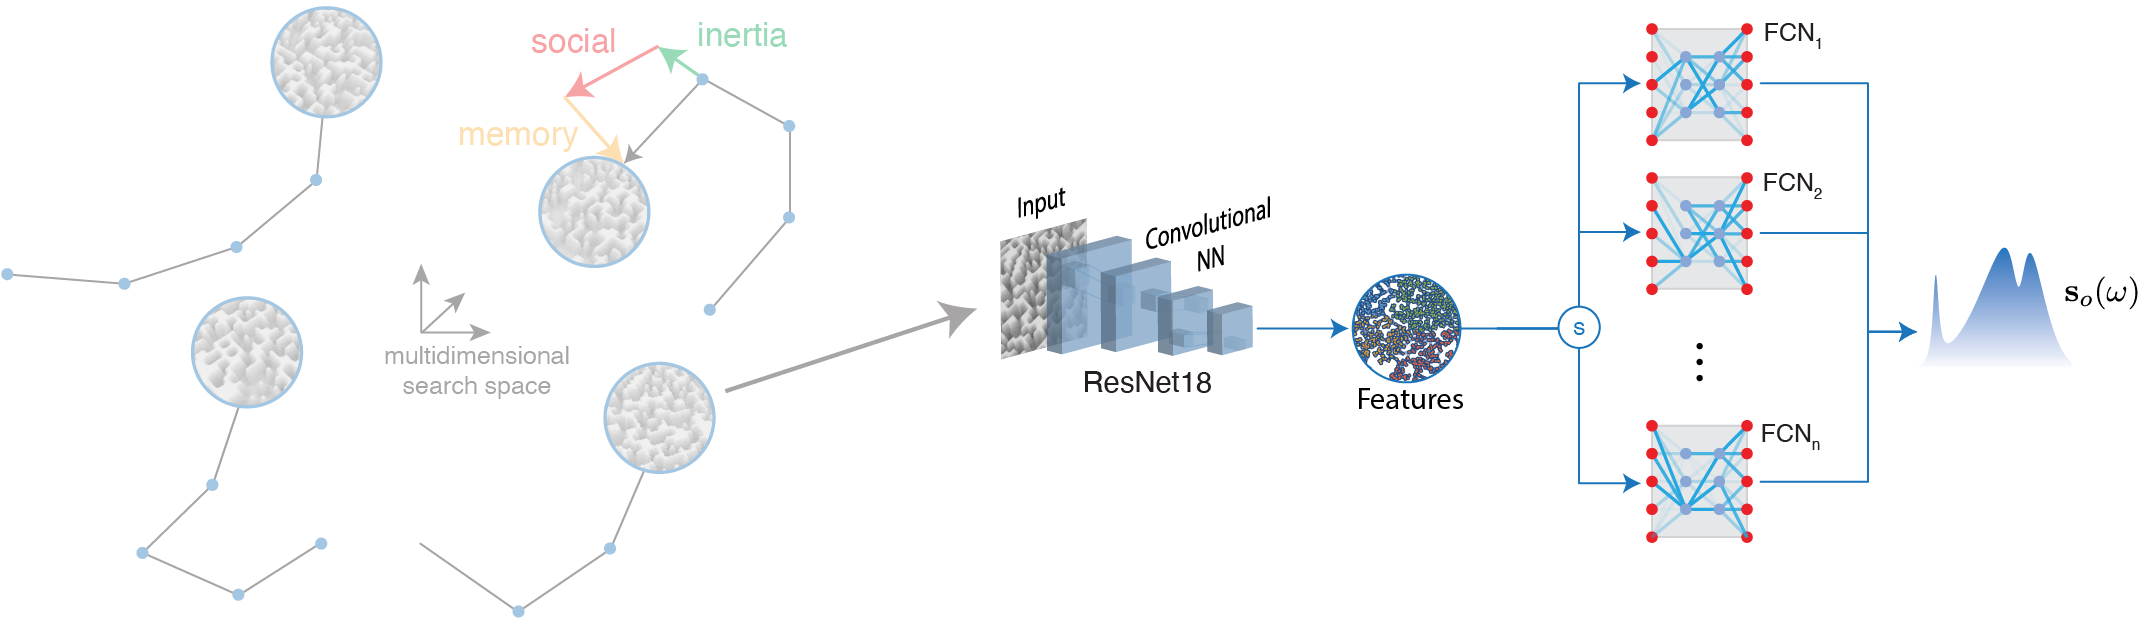

The purpose of the neural network prediction unit is to avoid having to compute the results of full FDTD simulations during the the search for an initial structure candidate. Once trained, the neural network can quickly and accurately predict the output of an FDTD simulation for a given geometry as we will show below. Interfacing with the predictor is done through the 'predictor.py' file available in the source folder.

In [ ]:
from predictor import NNSimulator
predictor = NNSimulator(saved_model=modeldir+'single.hdf5')

To evaluate the performance of the predictor, we can load the testing dataset and compare the optical response obtained through FDTD simulations to the predictor output.

In [ ]:
data = DataSet(npoints=80, datafile=['toydata'], input_shape=[100,100])
indices, X, y = data.get_all_sequences_in_memory('test',with_indices=True)

Below is a summary of the predictor performance and a visual comparison of the real and predicted responses for a set of random samples from the dataset. In this work we empirically establish a threshold at MSE=0.005, below which the prediction is considered satisfactory. The results below show that >98% of the predictions satisfy this condition.

In [ ]:
%%time
predictor.eval(X, y)
predictor.show_summary()

In [ ]:
def get_spectra(token):
    spectra = np.fromfile(filedir+token+'-spectra.bin',dtype=float).reshape(-1,5)
    wl, te, tm = spectra[:,0], spectra[:,1], spectra[:,2]
    return np.stack([wl,te,tm],axis=-1)

idx = np.random.randint(len(indices))
y = get_spectra(indices[idx])
predictor.show_mask_and_prediction(X,y=y,idx=idx,channel=0)

## Optimizer and example designs

The optimizer part described in original paper is based on a parallel realization of a Particle Swarm Optimization algorithm (PSO). The swarm parallel optimizer operates by searching a multidimensional space of solutions with an array of tentative geometries as particles that use a cooperative scheme based on the behavior of social insects. A population of candidate solutions, that we define as particles, is generated and these particles move around in the search-space based the particle's position and velocity. Each particle's movement is influenced by its local best known position, but is also guided toward the best known positions in the search-space, which are updated as better positions are found by other particles. This is expected to move the swarm toward the best solutions.

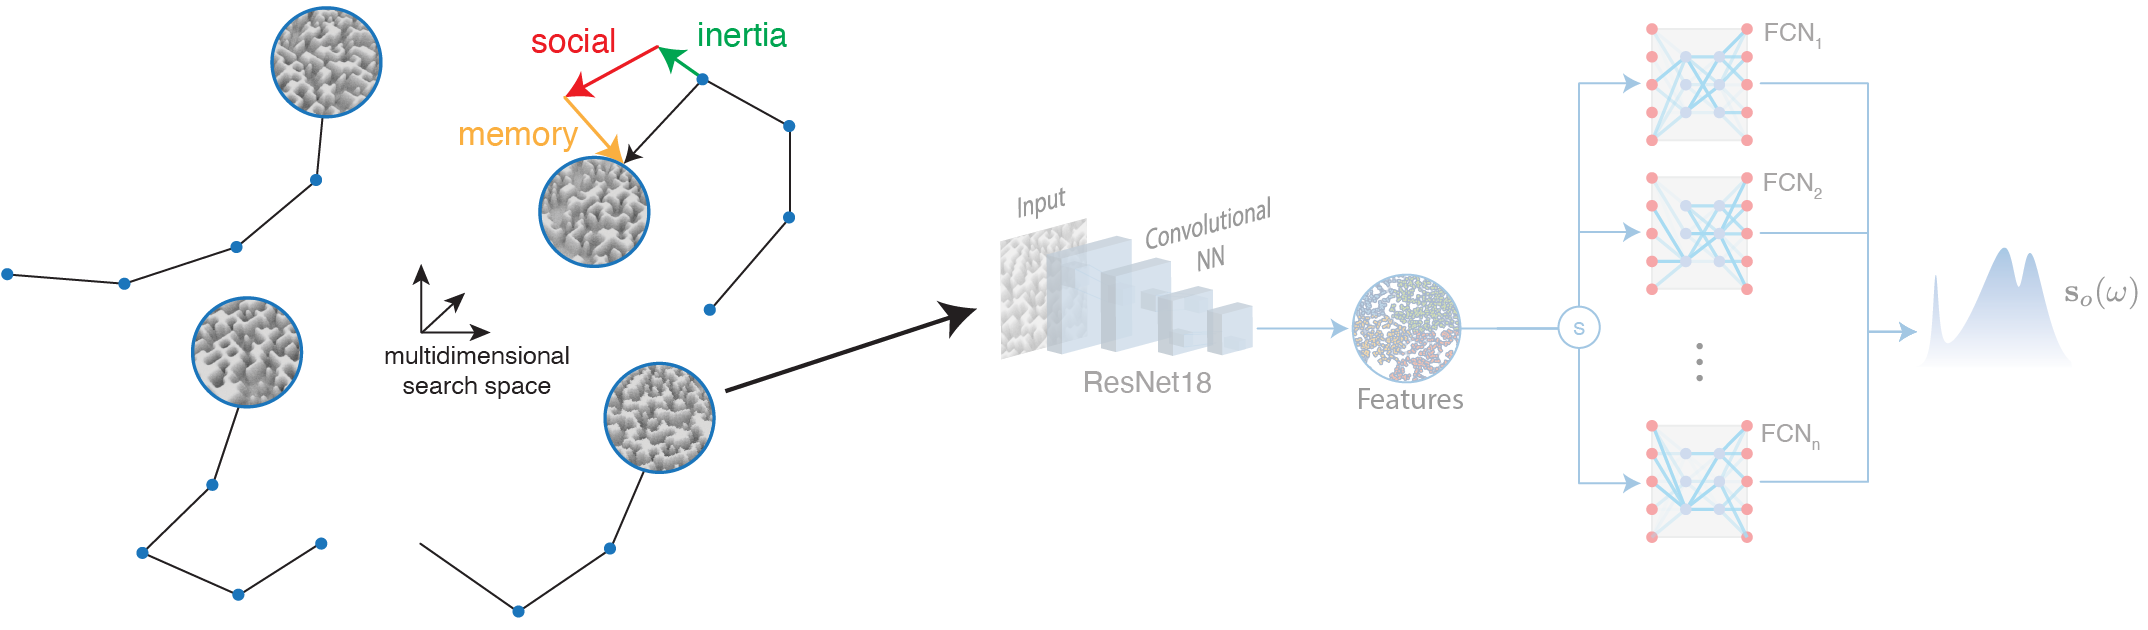



### Polarizer designs

As a first example we show how to use ALFRED to find high-efficiency optical polarizers. For demonstration purposes we use a simple cost function and work only with transmission.

While above we demonstrate how to train and use the predictor for single thickness samples, when searching for efficient solutions using inverse design assumptions on the sample such as fixed period or fixed thickness may heavily degrade the resulting design performance. In the original manuscript we propose an efficient way to connect and train the discrete parameter models, here we show a simplified version of that framework with the intent of conveying the general idea. The interface is similar to the single model case, with the difference of having multiple inputs and outputs in this case.

In [ ]:
from predictor import NNSimulator
K.clear_session()
predictor = NNSimulator(saved_model=[modeldir+"multiple_%d.hdf5" % i for i in range(3)])
#predictor = NNSimulator(saved_model='saved_weights/best_effnet2.hdf5')
#predictor.model.summary()

In [ ]:
from data import OnlineData as DataSet
batch_size = 10
nInputs = predictor.n_inputs
data = DataSet(input_shapes=[100]*nInputs)
X_gen=data.geometry_label_generator(batch_size,types=['rectangle'], min_size=10, max_shapes=3)
i = iter(X_gen)
inputs, labels = next(i)

In [ ]:
inputs, labels = next(i)
predictor.show_mask_and_prediction(inputs,idx=4)

In [ ]:
def cost(te,tm,central=800,dw=100):
    wl = np.linspace(300,1000,len(te))
    mask = (wl<(central+dw/2)) * (wl>(central-dw/2))
    return -np.abs(trapz(te[mask])-trapz(tm[mask]))

In [ ]:
from data import OnlineData as DataSet
from IPython.display import clear_output
from shapes import generate_random_shapes, Canvas, ShapelyShape as Shape
from preprocess import from_labels_to_x, from_x_to_labels, from_labels_to_image, from_x_to_image
from scipy.integrate import trapz
data = DataSet(input_shapes=[100])
batch_size=1000
X_gen=data.geometry_label_generator(batch_size,types=['rectangle'], min_size=10, max_shapes=3)
i = iter(X_gen)
X, labels = next(i)
idx = np.random.randint(len(labels))
x = from_labels_to_x(labels[idx])
l = from_x_to_labels(x)
plt.imshow(X[idx])
plt.show()

In [ ]:
input_shape = [100,100]

#number of parameters for rectangle
nparam = 4
#boundaries (with respect to input_shape)
wb=np.array([0.0,0.95])
lr = 0.1
central=0.6

n_inputs = predictor.n_inputs
n_outputs = predictor.n_outputs
pooling = np.min

#predictor = NNSimulator(saved_model='saved_weights/best_effnet2.hdf5')

def cost(te,tm,central=central*1e3,dw=100):
    wl = np.linspace(300,1000,len(te))
    mask = (wl<(central+dw/2)) * (wl>(central-dw/2))
    return -np.abs(trapz(te[mask])-trapz(tm[mask]))

############## INIT SINGLE PARTICLE FUNCTION                                                                                                                                                                                           
def init(x,v):
    # Center values;                                                                                                                                                                                                                   
    #init dz
    N = x.__len__() // nparam
    for i in range(N):
        xy_c = np.random.random(2)
        wx, wy = np.random.random(2) * (wb[1]-wb[0]) + wb[0]
        x[nparam*i:nparam*i+nparam] = xy_c[0],xy_c[1],wx,wy
        v[nparam*i:nparam*i+nparam] = (2*np.random.random(4)-1) * wb[1] * lr


def fun(X,predictor=predictor.predict_te_tm, input_shape=input_shape, cost=cost, pooling=pooling):
    X = np.array(X)
    batch = True
    if len(X.shape)<2:
        batch = False
        #add batch dimension
        X = np.expand_dims(X,axis=0)
    batch_size = X.shape[0]
    inputs = []
    for i in range(n_inputs):
        X_image = np.zeros([batch_size,*input_shape,1],dtype=np.int32)
        for i,x in enumerate(X):
            X_image[i] = np.expand_dims(from_x_to_image(x,input_shape),axis=-1)
        inputs.append(X_image)
    te_outputs, tm_outputs = predictor(inputs)
    fitnesses = []
    for i in range(n_outputs):
        te, tm = te_outputs[i], tm_outputs[i]
        fitnesses.append([cost(te,tm) for te, tm in zip(te, tm)])
    fitnesses = np.array(fitnesses).reshape(batch_size,n_outputs,-1)
    fitnesses= pooling(fitnesses,axis=1)
    if not batch:
        # if input is a single sample -> output also single
        fitnesses = fitnesses[0]
    return fitnesses

def bond(x):
    N = x.__len__() // nparam
    for i in range(N):
        xy_c = np.array(x[nparam*i:nparam*i+2])
        xy_c = np.mod(xy_c,1)
        w = np.array(x[nparam*i+2:nparam*i+4])
        w = np.minimum(w,wb[1])
        w = np.maximum(w,wb[0])
        xy_c=np.minimum(1-w/2,xy_c)
        xy_c=np.maximum(w/2,xy_c)
        x[nparam*i:nparam*i+nparam] = xy_c[0],xy_c[1],w[0],w[1]
        
# init the problem
nshapes = 2
opts={
    'dim':nshapes*nparam,
    'rng':1000,#839,#1734, #1625
    'swarmSize':30,#25
    'maxIter':100,
    'inertiaR':np.array([0.3,1.3]),
    'minNfrac':0.25,
    'cognitive':1.49,
    'social':5,#1.8,#1.49,
    'fun':fun,
    'boundary':bond,
    'init_part':init,
    }

from pso import pswarm

class optimizer(pswarm):
    def __init__(self,opts):
        self.opts = opts
        self.state=np.ones([opts['swarmSize'],opts['maxIter']])
        pswarm.__init__(self,opts)
    
    def update_stats(self):
        pswarm.update_stats(self)
        for i in range(self.swarmSize):
            self.state[i,self.currit] = self.swarm[i].fbest
    
    def show(self):
        clear_output()
        pswarm.show(self)
        plt.figure()
        for particle in self.state:
            particle = particle[particle<0]
            plt.plot(particle)
        plt.xlabel('current iteration')
        plt.ylabel('cost')
        plt.show()
        Xbest = np.expand_dims(from_x_to_image(self.gxbest,input_shape),axis=0)
        costs = fun(self.gxbest,pooling=(lambda x, axis=-1: x))
        i = np.argmin(costs)
        print(i)
        fig, axes = plt.subplots(1,2,figsize=[10,5])
        predictor.show_mask_and_prediction([Xbest]*n_inputs,channel=i,axes=axes)
        axes[0].set_xlim(central-0.2,central+0.2)
        axes[0].axvspan(central-0.05, central+0.05, alpha=0.2, color='green')
        fig.show()

#### Polarizer design result example

The following image exemplifies the result of running the optimizer in this notebook. On the top left is the optical response of the best device found by the swarm and predictor combination. The top right figure shows the geometry of the unit cell of the device. On the top left plots representing the value of the cost function for each particle are shown.

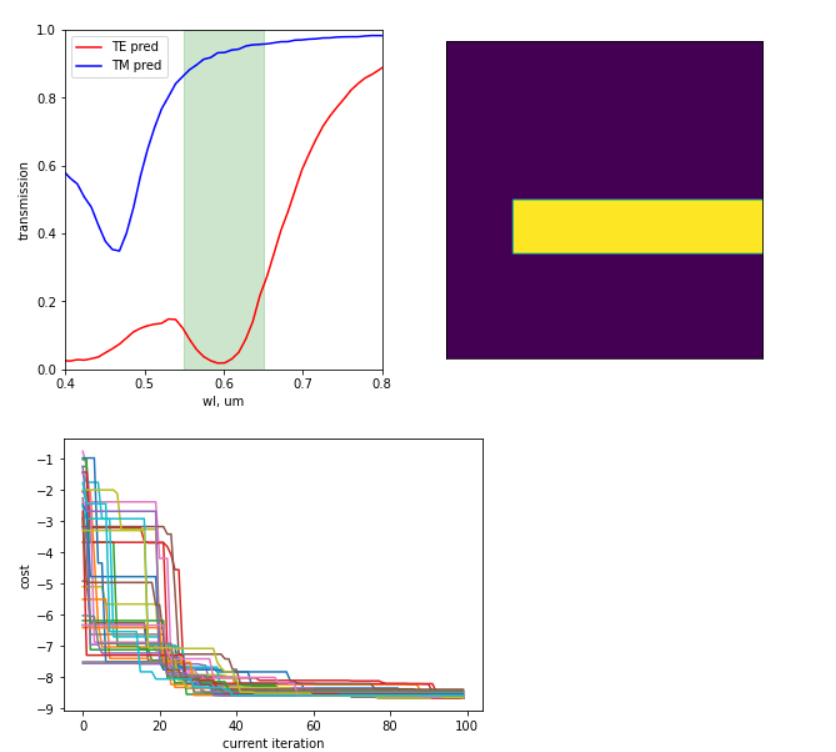

Running the next cell should produce a similar result to the above image, results may vary depending on the initial conditions of the swarm.

In [ ]:
polarizer_swarm = optimizer(opts)

In [ ]:
#central=0.8 # Design central wavelength must be changed above, on the cell above the picture
polarizer_swarm = optimizer(opts)

### Two sub-pixel color-display designs

All modern color displays operate on the principle that each pixel is subdivided into three elements, each of which is responsible for displaying a single primary color with a certain intensity. In the manuscript we propose a kind of display that requires only two subpixels per pixel to be able to produce color images. This is achieved through the use of two polarization dependent color filters that can switch between two colors each. This new kind of display allows a 33% power reduction in power consumption compared to conventional LCDs or a 33% resolution increase for a given area compared to any other three subpixel technology.

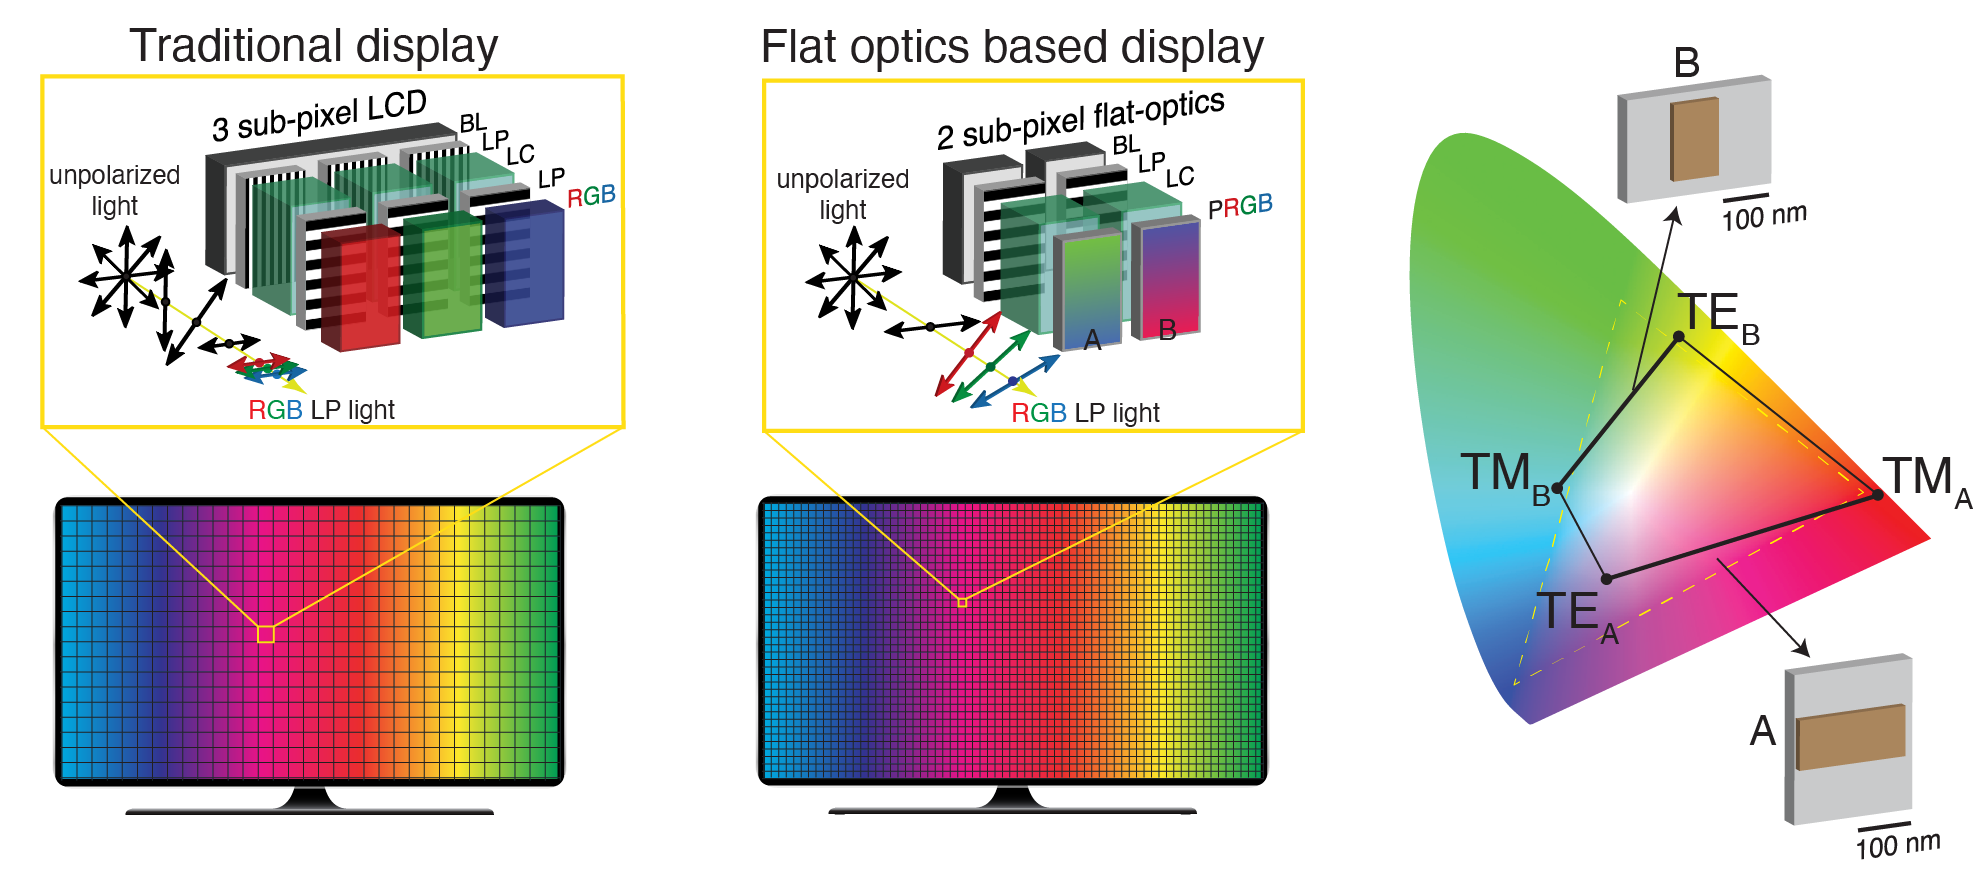


The design of the filters is done simultaneusly, with the cost function designed to maximize the gamut of colors that can be generated by combining both elements in the display. Below we demonstrate the design process for such a pair of devices


In [ ]:
from cost_functions import color_cost
from colors import color
from colour.plotting import plot_chromaticity_diagram_CIE1931

def get_color_xy(te,tm,xmin=300,xmax=1000):
    wl=np.linspace(xmin,xmax,len(te))
    te = np.stack([wl,te],axis = 1)
    tm = np.stack([wl,tm],axis = 1)
    te_xy = color(te).xy
    tm_xy = color(tm).xy
    return te_xy, tm_xy

In [ ]:
from data import OnlineData as DataSet
batch_size = 10
nInputs = predictor.n_inputs
data = DataSet(input_shapes=[100]*nInputs)
X_gen=data.geometry_label_generator(batch_size,types=['rectangle'], min_size=10, max_shapes=3)
i = iter(X_gen)
inputs, labels = next(i)

In [ ]:
input_shape = [100,100]

#number of parameters for rectangle
nparam = 4
#boundaries (with respect to input_shape)
wb=np.array([0.0,0.95])
lr = 0.1

def cost_multiple_outputs(output_1,output_2,cost):
    output_te_xy, output_tm_xy = output_1.reshape(n_outputs,2,2).transpose([1,0,2])
    output_te_xy2, output_tm_xy2 = output_2.reshape(n_outputs,2,2).transpose([1,0,2])
    fitnesses = []
    for te_xy, tm_xy in zip(output_te_xy, output_tm_xy):
        for te_xy2, tm_xy2 in zip(output_te_xy2, output_tm_xy2):
            fitnesses.append(-cost(te_xy,tm_xy,te_xy2,tm_xy2))
    fitnesses = np.array(fitnesses)
    idx = np.argmin(fitnesses)
    i,j = divmod(idx,n_outputs)
    return np.array([[output_te_xy[i],output_tm_xy[i]],
                     [output_te_xy2[j],output_tm_xy2[j]]]),fitnesses.reshape(n_outputs,n_outputs)

#predictor = NNSimulator(saved_model='saved_weights/best_effnet2.hdf5')

############## INIT SINGLE PARTICLE FUNCTION
#In case of optimizing colorspace volume with two metasurfaces, we need to run 2 simulations
def init2(x,v):
    # Center values;                                                                                                                                                                                                                   
    #init dz
    tmpx = x.reshape(-1,2)
    tmpv = v.reshape(-1,2)
    init(tmpx[:,0],tmpv[:,0])
    init(tmpx[:,1],tmpv[:,1])
    x[:len(x)//2]=tmpx[:,0]
    x[len(x)//2:]=tmpx[:,1]
    v[:len(x)//2]=tmpv[:,0]
    v[len(x)//2:]=tmpv[:,1]

#main function
def fun2(X,cost=color_cost,argmin=False,**kargs):
    X = X.reshape(x.shape[:-1] + (-1,2))
    #different outputs
    output_1 = fun(X[:,0],cost=get_color_xy,pooling=(lambda x, axis=-1: x))
    output_2 = fun(X[:,1],cost=get_color_xy,pooling=(lambda x, axis=-1: x))
    cie, fitnesses = cost_multiple_outputs(output_1,output_2,color_cost)
    if argmin:
        return divmod(fitnesses.argmin(),n_outputs), fitnesses.min(), cie
    return fitnesses.min()
    

def bond2(x):
    tmpx = x.reshape(-1,2)
    bond(tmpx[:,0])
    bond(tmpx[:,1])
    x[:len(x)//2]=tmpx[:,0]
    x[len(x)//2:]=tmpx[:,1]
        
# init the problem
nshapes = 2
opts={
    'dim':2*nshapes*nparam,
    'rng':1000,#839,#1734, #1625
    'swarmSize':200,#25
    'maxIter':500,
    'inertiaR':np.array([0.3,1.3]),
    'minNfrac':0.25,
    'cognitive':1.49,
    'social':3,#1.8,#1.49,
    'fun':fun2,
    'boundary':bond2,
    'init_part':init2,
    }

from pso import pswarm

class optimizer(pswarm):
    def __init__(self,opts):
        self.opts = opts
        self.state=np.ones([opts['swarmSize'],opts['maxIter']])
        pswarm.__init__(self,opts)
    
    def update_stats(self):
        pswarm.update_stats(self)
        for i in range(self.swarmSize):
            self.state[i,self.currit] = self.swarm[i].fbest
    
    def show(self):
        clear_output()
        pswarm.show(self)
        idx, _, (cie_1,cie_2) = fun2(self.gxbest,argmin=True)
        print(idx)
        plt.figure()
        for particle in self.state:
            particle = particle[particle<0]
            plt.plot(particle)
        plt.xlabel('current iteration')
        plt.ylabel('cost')
        plt.show()
        gxbest=np.array(self.gxbest).reshape(self.gxbest.shape[:-1] + (-1,2))
        Xbest0 = from_x_to_image(gxbest[:,0],input_shape)
        Xbest1 = from_x_to_image(gxbest[:,1],input_shape)
        plt.figure(figsize=[10,5])
        plt.subplot(121)
        plt.imshow(Xbest0)
        plt.subplot(122)
        plt.imshow(Xbest1)
        plt.show()
        plot_chromaticity_diagram_CIE1931(standalone=False)
        plt.plot(*list(zip(cie_1[0],cie_1[1])),'r')
        plt.plot(*list(zip(cie_2[0],cie_2[1])),'b')
        plt.show()    
    

#### Sub-pixels design result example
Below is an example result for the design of the sub-pixels. The top figure shows the evolution of the cost function for the swarm particles. Below are the unit cells of the designs found. The bottom figure shows a CIE 1931 diagram with two lines, each of these lines represents the chromaticities that an individual sub-pixel can change between as the input polarization is rotated
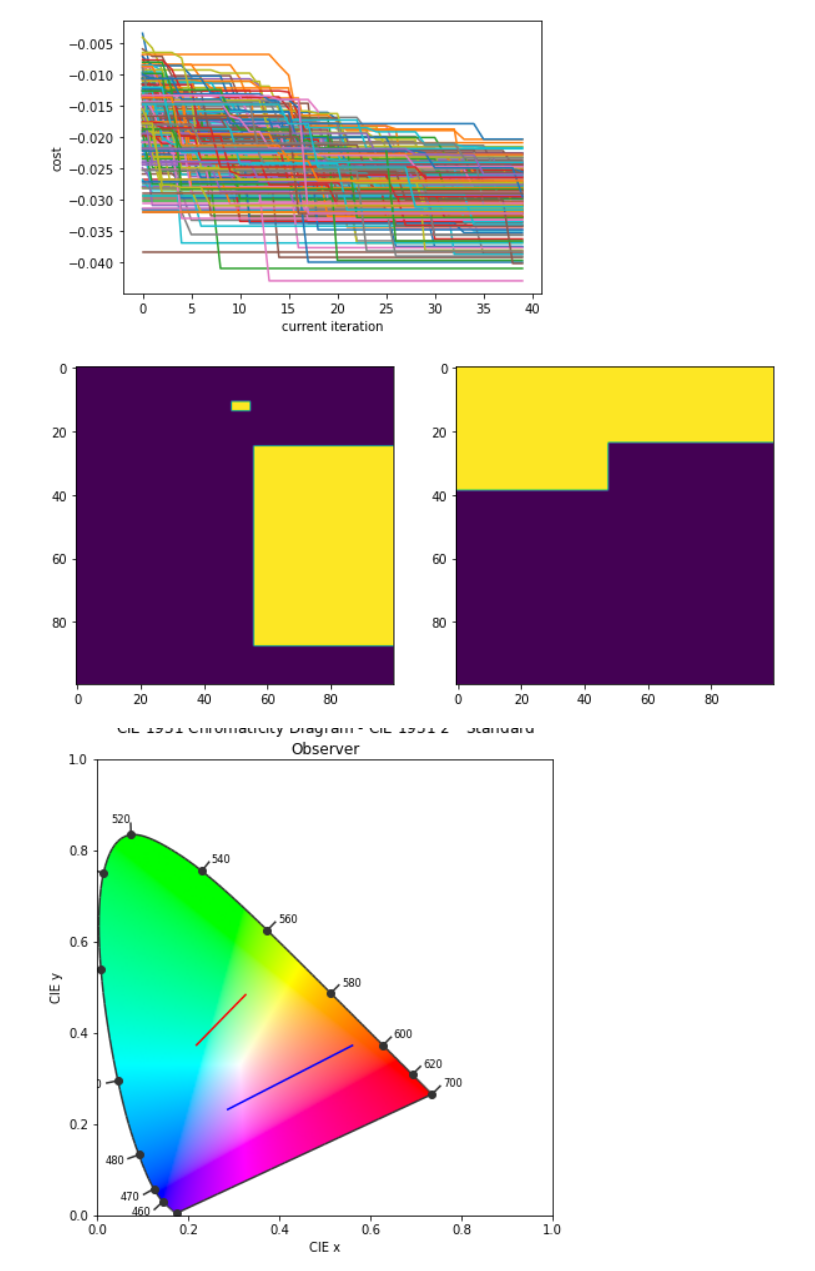

Running the cell below should produce a similar result to this figure

In [ ]:
color_swarm = optimizer(opts)